In [1]:
# importing lib
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tp
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
train_dir = "./train2"
valid_dir = "./valid"

# เช็คจำนวนไฟล์รูปภาพ
def count_files(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)
    return file_count

# ดูว่าค้นเจอไฟล์มั้ยกับเเสดงว่ามีกี่ไฟล์
print("Train Directory Exists:", os.path.exists(train_dir))
print("Validation Directory Exists:", os.path.exists(valid_dir))

if os.path.exists(train_dir):
    print("Number of Training Images:", count_files(train_dir))
else:
    print("Train Directory does not exist")

if os.path.exists(valid_dir):
    print("Number of Validation Images:", count_files(valid_dir))
else:
    print("Validation Directory does not exist")

Train Directory Exists: True
Validation Directory Exists: True
Number of Training Images: 1834
Number of Validation Images: 452


In [3]:
#กำหนด list train_x, train_y
train_x = []
train_y = []
test_x = []
test_y = []

In [4]:
#label class
class_label_encoding = {
    'SPOILED': 0,
    'HALF': 1,
    'FRESH': 2
}
print(class_label_encoding)

{'SPOILED': 0, 'HALF': 1, 'FRESH': 2}


In [5]:
#train_dir = "C:/Users/ACER/Downloads/Meat Freshness.v1-new-dataset.multiclass/train"

#ปรับขนาดภาพเพื่อให้ ง่ายต่อการคำนวณของ model
for file_name in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file_name)
    #print(f"Processing file: {file_path}")
    class_name = file_name.split('-')[0]
    i = 0
    if class_name == '_classes.csv': continue  # ในโฟล์เดอร์ train จะมีเก็บ csv ที่จำเเนก class (ignore file)
    img = cv2.imread(file_path)
    if img is None:
        print(f"Warning: Unable to read image {file_path}")
        i += 1
        continue
    img = img.astype('float32')  # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # ถ้าใช้ imread จะเเปลงไฟล์เป็น BGR เลยต้องเเปลงกลับเป็น RGB อีกรอบ
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)  # resize รูปเป็น 128 x 128
    img /= 255.  # normalize
    train_x.append(img)
    train_y.append(class_label_encoding[class_name])
#print(train_y)
print(f"Number of training samples: {len(train_x)}")
print(f"Number of training samples: {len(train_y)}")


Number of training samples: 1831
Number of training samples: 1831


In [6]:
from sklearn.model_selection import train_test_split

# เเปลง list เป็น array

import numpy as np
train_x = np.array(train_x)
train_y = np.array(train_y)
# เเบ่งข้อมูล
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(x_train.shape)

(1464, 128, 128, 3)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# สร้าง Data Augmentation เเบบ real-time
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# โมเดล
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),  # เพิ่มจำนวนฟิลเตอร์
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),  # เพิ่มเลเยอร์ Conv2D
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),  # เพิ่มจำนวนฟิลเตอร์
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),  # เพิ่มจำนวนหน่วยใน Dense layer
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(len(class_label_encoding), activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# กำหนด callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# เทรนโมเดล
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

d:\งูเหลือม\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


d:\งูเหลือม\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 26s 473ms/step - accuracy: 0.5334 - loss: 1.4327 - val_accuracy: 0.3161 - val_loss: 1.8452 - learning_rate: 0.0010
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - accuracy: 0.6579 - loss: 0.9287 - val_accuracy: 0.3161 - val_loss: 2.4991 - learning_rate: 0.0010
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 447ms/step - accuracy: 0.7450 - loss: 0.6766 - val_accuracy: 0.3161 - val_loss: 4.2746 - learning_rate: 0.0010
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.7854 - loss: 0.5636 - val_accuracy: 0.3161 - val_loss: 7.4370 - learning_rate: 0.0010
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.8057 - loss: 0.5345 - val_accuracy: 0.3161 - val_loss: 3.7831 - learning_rate: 0.0010
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.8217 - loss: 0.4816 - val_accuracy: 0.3161 - val_loss: 3.6915 - learning_rate: 0.0010
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.8030 - loss: 0.4550 - val_

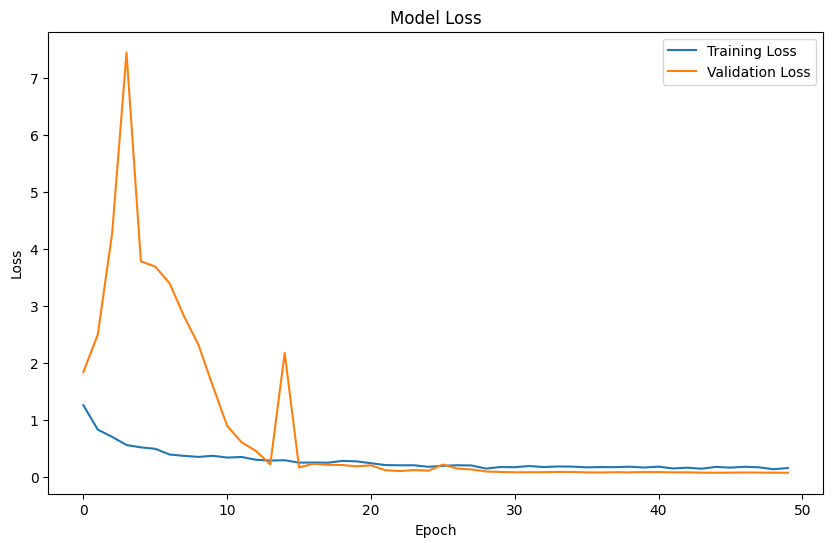

In [8]:
import matplotlib.pyplot as plt

# ดึงข้อมูล loss จากการเทรน
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# สร้างกราฟ
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
#โหลด model
#model.summary()
valid_dir = "./valid"
test_x = []
test_y = []

for file_name in os.listdir(valid_dir):
    file_path = os.path.join(valid_dir, file_name)
    class_name = file_name.split('-')[0]
    if class_name == '_classes.csv': continue
    img = cv2.imread(file_path)
    if img is None:
        print(f"Warning: Unable to read image {file_path}")
        continue
    img = img.astype('float32')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
    img /= 255.0
    test_x.append(img)
    test_y.append(class_label_encoding[class_name])

#เปลี่ยน type list ให้เป็น array เพื่อใช้ train model
test_x = np.array(test_x, dtype='float32')
test_y = np.array(test_y, dtype='int')

#เช็ค test data
print(type(test_x), test_x.dtype)
print(type(test_y), test_y.dtype)
print(test_x.shape)
print(test_y.shape)

test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

predictions = model.predict(test_x)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)


<class 'numpy.ndarray'> float32
<class 'numpy.ndarray'> int32
(451, 128, 128, 3)
(451,)
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9674 - loss: 0.0913
Test loss: 0.08723413944244385
Test accuracy: 0.9756097793579102
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


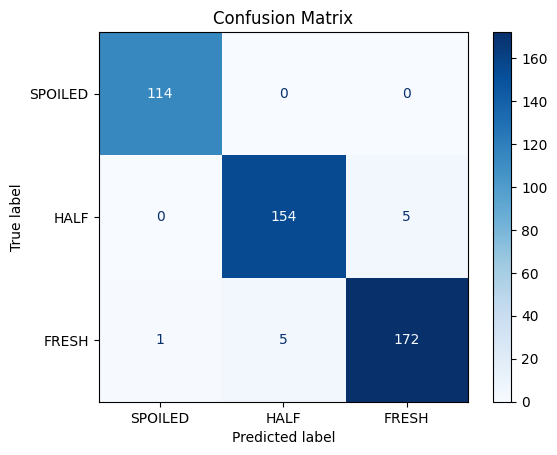

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#ทำ confusion metrix
predictions = model.predict(test_x)
predicted_labels = np.argmax(predictions, axis=1)

class_names = {v: k for k, v in class_label_encoding.items()}
cm = confusion_matrix(test_y, predicted_labels)

#โชว์ confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_names.values()))

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [14]:
# คำนวณหาค่า F1
from sklearn.metrics import f1_score
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # แปลงเป็น class ที่ทำนาย
f1 = f1_score(y_val, y_pred_classes, average='weighted')
print("F1 Score:", f1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
F1 Score: 0.9700824425985545


In [15]:
# คำนวณค่า Precision และ Recall
import numpy as np
from sklearn.metrics import precision_score, recall_score

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # แปลงเป็น class ที่ทำนาย

precision = precision_score(y_val, y_pred_classes, average='weighted')
recall = recall_score(y_val, y_pred_classes, average='weighted')
print("Precision:", precision)
print("Recall:", recall)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Precision: 0.9702034274610822
Recall: 0.9700272479564033


In [12]:
model.save('meat_freshness_model_add_layer.h5')